In [1]:
using JLD2

include("../train_NN.jl")
include("../generate_data.jl")
include("model.jl")
include("../viz.jl")

#@load joinpath(MODEL_DIR, "train_data.jld2") X_train y_train
#@load joinpath(MODEL_DIR, "valid_data.jld2") X_valid y_valid
@load joinpath(MODEL_DIR, "test_data.jld2") X_test y_test

#train_data = (X_train, y_train)
#valid_data = (X_valid, y_valid)
test_data = (X_test, y_test);

In [2]:
@load joinpath(MODEL_DIR, "model.jld2") model
model.nn

Chain(
  InputLayer(),
  Dense(17, 1024, relu),                # 18_432 parameters
  Split(
    Tuple(
      Dense(1024, 6, exp),              # 6_150 parameters
      Dense(1024, 6, σ),                # 6_150 parameters
      Chain(
        Dense(1024, 6),                 # 6_150 parameters
        NNlib.softmax,
      ),
    ),
  ),
)                   # Total: 8 arrays, 36_882 parameters, 144.695 KiB.

In [3]:
println("KL divergence")
#println("train ", mean_loss(train_data..., model; loss=loss_kldivergence))
#println("valid ", mean_loss(valid_data..., model; loss=loss_kldivergence))
println("test ", mean_loss(test_data..., model; loss=loss_kldivergence))

println("Hellinger distance")
#println("train ", mean_loss(train_data..., model; loss=loss_hellinger))
#println("valid ", mean_loss(valid_data..., model; loss=loss_hellinger))
println("test ", mean_loss(test_data..., model; loss=loss_hellinger))

KL divergence
test 0.03028967
Hellinger distance
test 0.047245186


## Example distributions

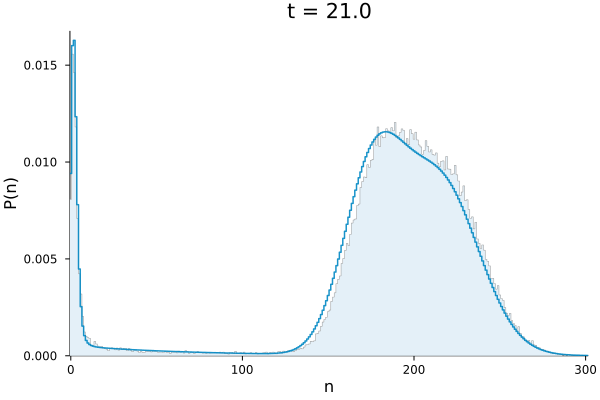

In [145]:
#ind = rand(1:length(X_train)); plot_dist(X_train[ind], train_data, model)
#ind = rand(1:length(X_valid)); plot_dist(X_valid[ind], valid_data, model)
ind = rand(1:length(X_test)); plot_dist(X_test[ind], test_data, model)
plot!(leg=false)

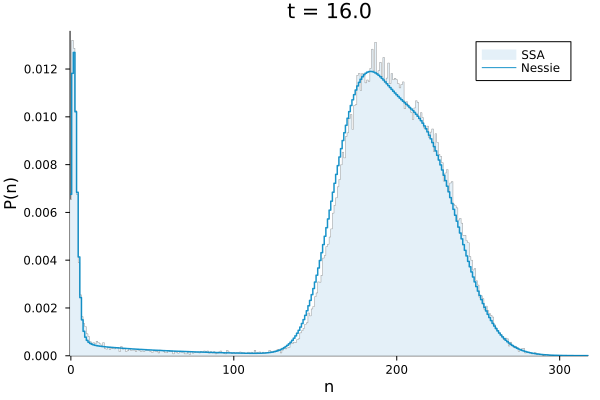

In [150]:
ind = 7816; plot_dist(X_test[ind], test_data, model)

In [199]:
# set up SSA

@variables t G_uA(t) G_uB(t) P_A(t) P_B(t)
u0 = zeros(Int, numspecies(rn))
u0[[speciesmap(rn)[i] for i in (G_uA, G_uB)]] .= 1

jsys = convert(JumpSystem, rn, combinatoric_ratelaw=false)           
dprob = DiscreteProblem(jsys, u0, (0.0, 100.0), zeros(Float64, numreactionparams(rn)))
jprob = JumpProblem(jsys, dprob, Direct(), save_positions=(false, false))

idx = speciesmap(rn)[P_B]   # target protein
solver(ts, p) = ssa_solve(jprob, ts, p, 100000; marginals=[idx])

solver (generic function with 1 method)

In [242]:
# rounded X_test[4035]
p = Float32.([0.0005, 0.07, 0.00016, 0.068, 367.3, 119.9, 5.3, 14.36, 1.35, 413.2, 472.3, 11.9, 1.74, 0.98, 0.43, 65.6])
t = 35f0
ps = vcat(t, p)

@time _data = build_dataset([t], [p], solver)
@save joinpath(MODEL_DIR, "example_SSA_1.jld2") _data

326.260518 seconds (56.49 M allocations: 3.204 GiB, 1.06% gc time, 0.02% compilation time)


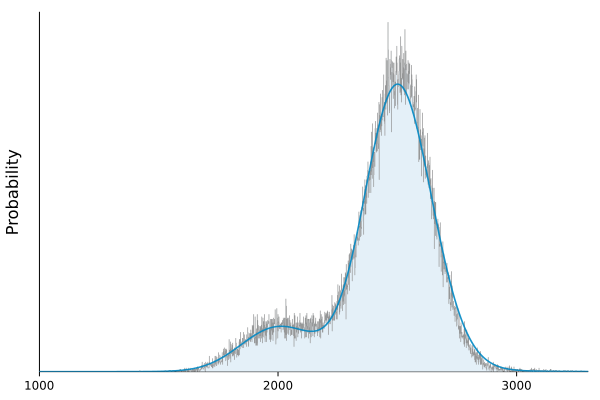

In [185]:
@load joinpath(MODEL_DIR, "example_SSA_1.jld2") _data
plt1 = plot_dist(_data[1][1], _data, model; true_label="SSA")
plt1 = plot!(plt1, xlabel="", ylabel="Probability", title="", leg=false,
             yticks=false, xticks = (1000:1000:3000, [1000, 2000, 3000]), xlims=(1000, 3300),
             left_margin=4Plots.mm)   #size=(250, 300)

In [244]:
# rounded X_test[16170]
p = Float32.([0.0003, 0.018, 0.00002, 0.02, 222.3, 474.9, 3.98, 6.96, 0.68, 359.9, 82.1, 4.2, 7.13, 0.1, 0.41, 68.4])
t = 70f0

ps = vcat(t, p)
@time _data = build_dataset([t], [p], solver)
@save joinpath(MODEL_DIR, "example_SSA_2.jld2") _data

193.011420 seconds (56.44 M allocations: 3.202 GiB, 1.38% gc time)


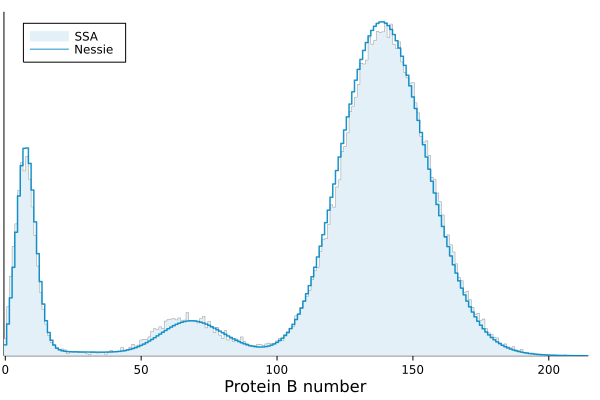

In [161]:
@load joinpath(MODEL_DIR, "example_SSA_2.jld2") _data
plt2 = plot_dist(_data[1][1], _data, model; true_label="SSA")
plt2 = plot!(plt2, xlabel="Protein B number", ylabel="", title="", leg=:topleft,
             yticks=false, #size=(350, 300),
             left_margin=-1Plots.mm)

In [246]:
# rounded X_test[13600]
p = Float32.([0.0002, 0.005, 0.00035, 0.046, 371.2, 69.1, 7.1, 13.9, 0.87, 128.0, 452.7, 8.4, 11.98, 1.1, 0.2, 72.6])
t = 100f0

ps = vcat(t, p)
@time _data = build_dataset([t], [p], solver)
@save joinpath(MODEL_DIR, "example_SSA_3.jld2") _data

270.684501 seconds (56.44 M allocations: 3.202 GiB, 0.89% gc time)


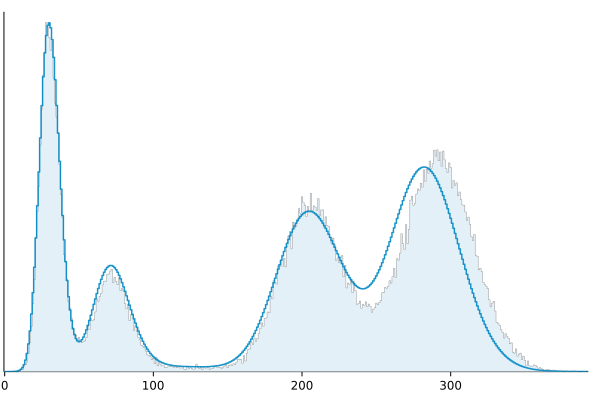

In [162]:
@load joinpath(MODEL_DIR, "example_SSA_3.jld2") _data
plt3 = plot_dist(_data[1][1], _data, model; true_label="SSA")
plt3 = plot!(plt3, xlabel="", ylabel="", title="", leg=false,
             yticks=false, #size=(350, 300),
             left_margin=-1Plots.mm)

In [200]:
# rounded X_test[7816]
p = Float32.([0.0002, 0.06, 0.00048, 0.095, 328.3, 190.2, 11.1, 15.84, 1.01, 467.9, 11.3, 8.7, 13.91, 1.14, 0.17, 92.2])
t = 16f0
ps = vcat(t, p)

@time _data = build_dataset([t], [p], solver)
@save joinpath(MODEL_DIR, "example_SSA_4.jld2") _data

 57.006271 seconds (56.58 M allocations: 3.394 GiB, 0.08% compilation time)


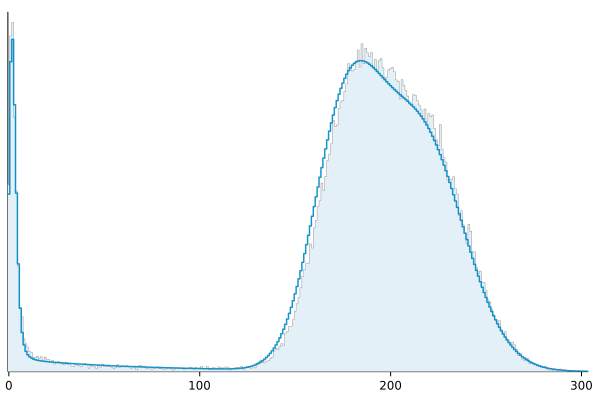

In [201]:
@load joinpath(MODEL_DIR, "example_SSA_4.jld2") _data
plt4 = plot_dist(_data[1][1], _data, model; true_label="SSA")
plt4 = plot!(plt4, xlabel="", ylabel="", title="", leg=false,
             yticks=false, #xticks = (1000:1000:3000, [1000, 2000, 3000]), xlims=(1000, 3300),
             left_margin=0Plots.mm)   #size=(250, 300)

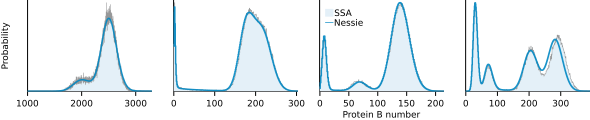

In [205]:
l = @layout [a b c d]
#l = @layout [a{0.25w} b c]
#plt = plot(plt1, plt2, plt3, layout=l, size=(350, 110), bottom_margin=0Plots.mm, top_margin=-2Plots.mm,
#           guidefontsize=6, tickfontsize=6, legendfontsize=6, thickness_scaling=1.0, left_margin=1Plots.mm, right_margin=-2Plots.mm,
#           foreground_color_legend = nothing, fmt=:svg)
plt = plot(plt1, plt4, plt2, plt3, layout=l, size=(590, 120), bottom_margin=2Plots.mm, top_margin=-2Plots.mm,
           guidefontsize=6, tickfontsize=6, legendfontsize=6, thickness_scaling=1.0, left_margin=3.5Plots.mm, right_margin=-2Plots.mm,
           foreground_color_legend = nothing, fmt=:svg)

In [206]:
savefig(joinpath(MODEL_DIR, "example_dists.svg"))

## Predicted vs true moments

In [40]:
# plotting points only for t=100
ind = 100
m = 100
m_NN = mean.(Distribution.(Ref(model), X_test[ind:m:end]))
var_NN = var.(Distribution.(Ref(model), X_test[ind:m:end]))

m_SSA = [sum((0:length(y)-1) .* y) for y in y_test[ind:m:end]]
var_SSA = [sum(((0:length(y)-1) .- m_SSA[i]) .^2  .* y) for (i, y) in enumerate(y_test[ind:m:end])];

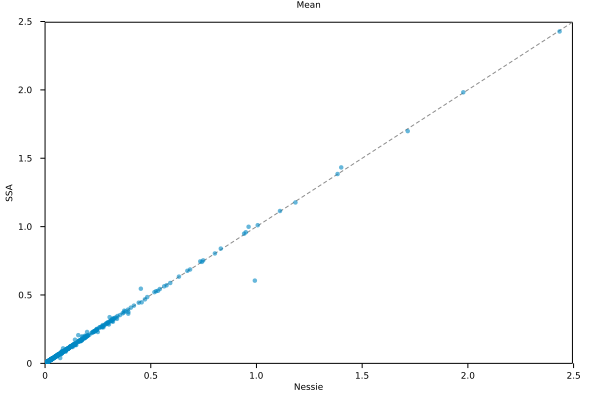

In [59]:
scale = 1e-3
max_val = maximum(vcat(m_SSA, m_NN))* 1.025 * scale
xticks = (0:0.5:2.5, ["0", (0.5:0.5:2.5)...])
plt1 = plot(0:ceil(max_val), 0:ceil(max_val), linestyle=:dash, linecolor=:gray, linealpha=0.9, leg=false, 
             xlabel="Nessie", ylabel="SSA", title="Mean")
plt1 = scatter!(plt1, m_NN .* scale, m_SSA .*scale, grid = false, xlim=(0, max_val), ylim=(0, max_val), 
                markersize=2.5, markercolor=colorant"#0088c3ff", markerstrokecolor=colorant"#0088c3ff", 
                alpha=0.6, xticks=xticks, yticks=xticks)
plt1 = plot!(plt1, guidefontsize=6, tickfontsize=6, titlefontsize=6, thickness_scaling=1.0, 
             framestyle=:box, tick_direction=:out, right_margin=5Plots.mm)
plt1 = annotate!(plt1, [(-0.4, -0.4, Plots.text("×10³", 6, :black, :center))])

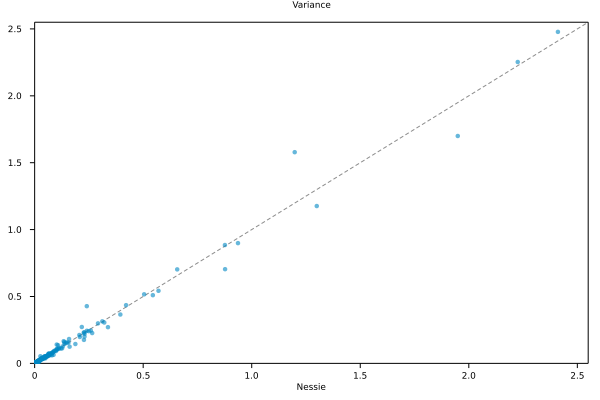

In [60]:
scale = 1e-5
max_val = 2.55 #maximum(vcat(var_SSA, var_NN)) * 1.025 * scale
xticks = (0:0.5:2.5, ["0", (0.5:0.5:2.5)...])
plt2 = plot(0:ceil(max_val), 0:ceil(max_val), linestyle=:dash, linecolor=:gray, linealpha=0.9, leg=false, 
            xlabel="Nessie", ylabel="", title="Variance")
plt2 = scatter!(plt2, var_NN .* scale, var_SSA .* scale, grid = false, xlim=(0, max_val), ylim=(0, max_val), 
                markersize=2.5, markercolor=colorant"#0088c3ff", markerstrokecolor=colorant"#0088c3ff", 
                alpha=0.6, xticks=xticks, yticks=xticks)
plt2 = plot!(plt2, guidefontsize=6, tickfontsize=6, titlefontsize=6, thickness_scaling=1.0,
             framestyle=:box, tick_direction=:out)
plt2 = annotate!(plt2, [(-0.4, -0.4, Plots.text("×10⁵", 6, :black, :center))])

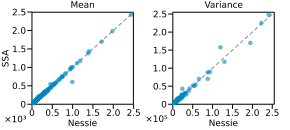

In [76]:
plot(plt1, plt2, size=(290, 130), 
    left_margin=-1Plots.mm, bottom_margin=0Plots.mm, top_margin=-1Plots.mm, right_margin=2Plots.mm)

In [77]:
savefig(joinpath(MODEL_DIR, "true_vs_predict_moments.svg"))

## Interpolation in time

In [207]:
m = 100; l = length(X_test)
tpts = [2, 4, 10, 16, 32, 50, 74, 100]

@time accs = map(1:m) do i
    inds = i:m:l
    mean_loss(X_test[inds], y_test[inds], model; loss=loss_hellinger)
end;

  3.271963 seconds (1.21 M allocations: 825.646 MiB, 5.20% compilation time)


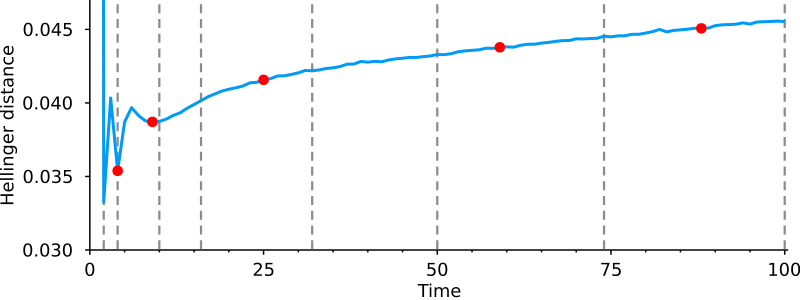

In [480]:
# Hellinger distance is really high for t < 4
plt = vline(tpts, linestyle=:dash, alpha=0.9, lw=1.5, color=:gray)
plt = plot!(plt, 1:m, accs[1:end], ylims=(0.03, 0.047), xlims=(0., 100.5), color=1, lw = 2, 
            xlabel="Time", ylabel="Hellinger distance", grid=false, leg=false, xminorticks=5)
inds = [4, 9, 25, 59, 88]
plt = scatter!(plt, inds, accs[inds], color=:red, markerstrokecolor=:red)
plt = plot!(size=(800, 300), tick_orientation=:out, guidefontsize=8, tickfontsize=8, thickness_scaling=1.5,
            bottom_margin=0Plots.mm, right_margin=0Plots.mm, top_margin=-2Plots.mm, left_margin=-5Plots.mm)

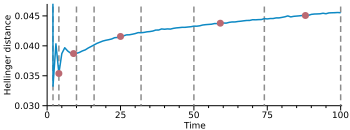

In [387]:
# Hellinger distance is really high for t < 4
plt = vline(tpts, linestyle=:dash, alpha=0.9, lw=1.5, color=:gray)
plt = plot!(plt, 1:m, accs[1:end], ylims=(0.03, 0.047), xlims=(0., 100.5), color=colorant"#0d89c4", lw = 1.5, 
            xlabel="Time", ylabel="Hellinger distance", grid=false, leg=false, xminorticks=5)
inds = [4, 9, 25, 59, 88]
plt = scatter!(plt, inds, accs[inds], color=colorant"#bb6972", markerstrokecolor=colorant"#bb6972", markerstrokewidth=1.0)
plt = plot!(size=(350, 130), tick_orientation=:out,
            guidefontsize=6, tickfontsize=6, thickness_scaling=1.0,
            bottom_margin=0Plots.mm, right_margin=0Plots.mm, top_margin=-1Plots.mm, left_margin=0Plots.mm)

In [388]:
savefig(joinpath(MODEL_DIR, "hell_vs_time.svg"))

In [341]:
function plot_ts(ind, tinds, data)
    ind = ind*m
    plts = []
    #legend=true
    for i in tinds
        #legend = i == tinds[2] ? true : false
        legend = false
        ylabel = i == tinds[1] ? "Probability" : ""
        xlabel = i == tinds[3] ? "Protein B number" : ""
        left_margin = i == tinds[1] ? 2Plots.mm : 0Plots.mm
        plt = plot_dist(data[1][ind+i], data, model, legend=legend, title="", xlims=(0., 325),
                ylabel=ylabel, xlabel=xlabel, yticks=false, left_margin=left_margin)
        y = ylims(plt)[2] * 0.92
        x = xlims(plt)[2] * 0.16
        plt = annotate!(plt, [(x, y, Plots.text("t = $i", 6, :black, :center))])
        push!(plts, plt)
    end
    plot(plts..., fmt=:svg, size=(600, 115), layout = (1, length(plts)), 
         guidefontsize=6, tickfontsize=6, legendfontsize=6, thickness_scaling=1.0,
         bottom_margin=2Plots.mm, top_margin=0Plots.mm, left_margin=4Plots.mm, right_margin=-2Plots.mm)
end

plot_ts (generic function with 1 method)

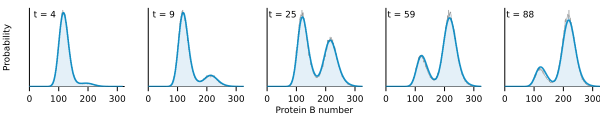

In [342]:
ind = 112
plt = plot_ts(ind, inds, test_data)

In [463]:
solver(ts, p) = ssa_solve(jprob, ts, p, 100000; marginals=[idx])

solver (generic function with 1 method)

In [464]:
# rounded X_test[11200]
p = Float32.([0.0004, 0.06, 0.00022, 0.0034, 269.7, 61.3, 8.02, 9.46, 1.78, 307.7, 351.2, 10.1, 12.27, 0.09, 0.38, 85.6])
ts = 1:1:100

@time _data = build_dataset(ts, [p], solver)
@save joinpath(MODEL_DIR, "SSA_time_dists.jld2") _data

280.747757 seconds (66.40 M allocations: 4.527 GiB, 1.16% gc time, 0.02% compilation time)


In [277]:
@load joinpath(MODEL_DIR, "SSA_time_dists.jld2") _data

1-element Vector{Symbol}:
 :_data

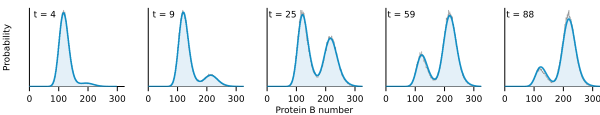

In [343]:
plot_ts(0, inds, _data)

In [344]:
savefig(joinpath(MODEL_DIR, "time_dists.svg"))

## Sensitivity Analysis

In [5]:
function model_FF(model, ts, p)
    m = [mean(model, vcat(t, p)) for t in ts]
    v = [var(model, vcat(t, p)) for t in ts]
    v ./ m
end

model_FF (generic function with 1 method)

In [6]:
log_sens_model(model, t::Number, p) = vcat(log_sens_model(model, [t], p)...)

function log_sens_model(model, ts::AbstractArray, p)
    # logarithmic sensitivities of the form (pᵢ/FF)*(∂FF/∂pᵢ)
    res = Flux.jacobian(x -> model_FF(model, ts, x), p)
    x, dx = model_FF(model, ts, p), res[1]
    dx ./ x .* p'
end

log_sens_model (generic function with 2 methods)

In [389]:
using Sobol

ranges = [ 0   0.0005  # σ_bB 
           0   0.1     # σ_uB
           0   0.0005  # σ_bA
           0   0.1     # σ_uA
           0   500     # ρ_uA
           0   500     # ρ_bA
           0   12      # γ_A 
           1   20      # δ_mA  
           0   2       # δ_p
           0   500     # ρ_uB
           0   500     # ρ_bB 
           0   12      # γ_B
           1   20      # δ_mB
           0   2       # σ_uM
           0   0.5     # σ_bM
           0   100     # δ_pm   
         ]

s = SobolSeq(ranges[:,1], ranges[:,2])
x_data = [ Sobol.next!(s) for i in 1:100000 ];

In [8]:
@time model_FF(model, [100f0], x_data[1])

  1.882750 seconds (4.85 M allocations: 262.950 MiB, 3.47% gc time, 99.99% compilation time)


1-element Vector{Float64}:
 1.7293303197908299

In [9]:
@time log_sens_model(model, [100f0], x_data[1])

 69.049997 seconds (106.09 M allocations: 5.729 GiB, 2.49% gc time, 99.88% compilation time)


1×16 Matrix{Float64}:
 0.00859229  0.00787192  0.0089154  …  -0.00165646  0.0714173  0.000819938

In [391]:
xs = @time log_sens_model.(Ref(model), Ref(100f0), x_data[1:end]);

168.233461 seconds (474.10 M allocations: 121.687 GiB, 5.68% gc time)


In [393]:
max_xs = [argmax(abs.(x)) for x in xs] 
min_xs = [argmin(abs.(x)) for x in xs]

list = countmap(max_xs)
most_s = zeros(Int, numreactionparams(rn))
for i in 1:length(most_s)
    if haskey(list, i)
        most_s[i] = list[i]
    else
        most_s[i] = 0
    end
end

list = countmap(min_xs)
least_s = zeros(Int, numreactionparams(rn))
for i in 1:length(least_s)
    if haskey(list, i)
        least_s[i] = list[i]
    else
        least_s[i] = 0
    end
end

syms = string.(reactionparams(rn));

In [13]:
cmap_new = [ colorant"#0d89c4", colorant"#2996cb", colorant"#46a4d2", colorant"#63b2d9", colorant"#80c0e0", 
             colorant"#9dcee7", colorant"#badcee", colorant"#d7eaf5", colorant"#f4f8fc", colorant"#eae0e5", 
             colorant"#e1c8ce", colorant"#d7b0b7", colorant"#ce99a0", colorant"#c58189", colorant"#bb6972", 
             colorant"#b2515b", colorant"#a93a45" ]

In [32]:
using Plots: partialcircle

@recipe function f(::Type{Val{:pie}}, x, y, c)
    framestyle --> :none
    aspect_ratio --> true
    s = sum(y)
    θ = π/2
    for i in eachindex(y)
        θ_new = θ + 2π * y[i] / s
        coords = [(0.0, 0.0); partialcircle(θ, θ_new, 100)]
        @series begin
            seriestype := :shape
            linecolor := :black
            seriescolor := cmap[i]
            label --> string(x[i])
            x := first.(coords)
            y := last.(coords)
        end
        θ = θ_new
    end
end

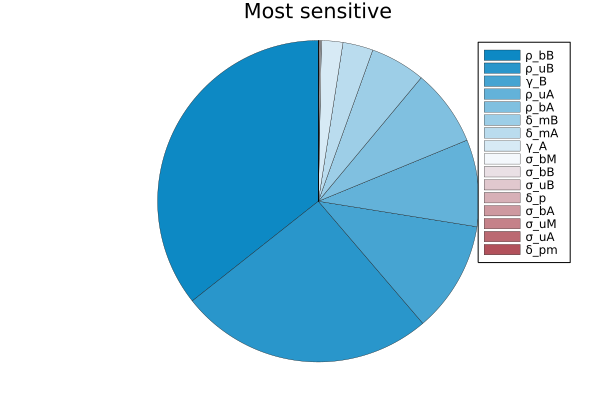

In [398]:
    cmap = cmap_new
    inds = sortperm(most_s, rev=true)
    p1 = pie(syms[inds], most_s[inds], lw=0.3, title="Most sensitive")

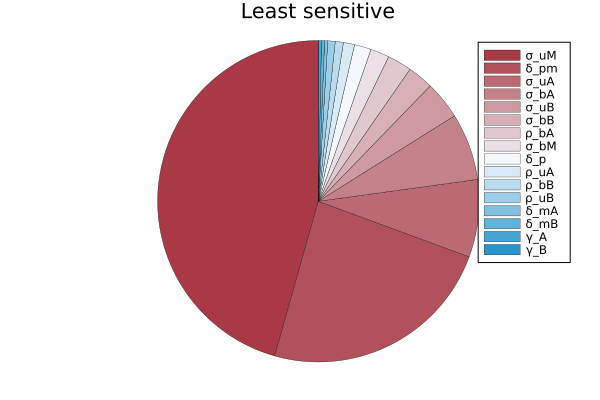

In [403]:
cmap = reverse(cmap_new)
inds = sortperm(least_s, rev=true)
p2 = pie(syms[inds], least_s[inds], lw=0.3, title="Least sensitive")

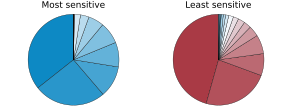

In [402]:
plot(p1, p2, size=(290, 110), titlefontsize=6, leg=false,
    left_margin=-10Plots.mm, bottom_margin=-4Plots.mm, top_margin=-1Plots.mm, right_margin=-2Plots.mm)

In [401]:
savefig(joinpath(MODEL_DIR, "sensitivity_pies.svg"))